In [15]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import copy
from matplotlib import colors
from sklearn import tree
#import skfda
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import timeshap
from timeshap.explainer import event_level, feature_level

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import scipy.signal
#import cartopy.crs as ccrs
#import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
#import torch.nn.functional as F
#from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
from WaveNet_fctns import *
#from suntimes import SunTimes  

In [16]:
def ML_tensor_from_ds(ds):
    ds=ds.rename(columns={'Referenzjahr':'year'})
    #print(len(ds))
    ds = ds.dropna(how='all')
    #print(len(ds))
    ds = ds.loc[ds['observed time to beginning of flowering'] < 140]
    skip = 1
    numsteps = int(163 // skip)
    new_series = []
    ds.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
    ds.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
    for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']:#['t2m', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
        data = ds[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
        #if variable_name != 't2m' and variable_name != 'photoperiod':
        #    scaler = StandardScaler()
        #    scaler.fit(data)
        #    data = scaler.transform(data)
        new_variable_series = torch.Tensor(data)
        new_series.append(new_variable_series)

    day_series = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds))])
    year_series = torch.Tensor([ds['year'].values for count in range(numsteps)]).T
    id_series = torch.Tensor([ds['Stations_id'].values for count in range(numsteps)]).T
    pd.Categorical(ds['Management'], categories= ['Drought', 'Low N', 'Low pH', 'Maize Streak Virus', 'Optimal']).codes
    var_series = torch.Tensor([pd.Categorical(ds['vargroup'], categories= ['EIHY', 'EPOP', 'ILHY', 'ILPO']).codes for count in range(numsteps)]).T
    man_series = torch.Tensor([pd.Categorical(ds['Management'], categories= ['Drought', 'Low N', 'Low pH', 'Maize Streak Virus', 'Optimal']).codes for count in range(numsteps)]).T
    X_tensor = torch.swapaxes(torch.stack((*new_series, day_series, var_series, man_series, year_series, id_series)), 0, 1)
    ds.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds),1))
    ds.loc[:, [f'dev stage at day {skip*n}' for n in range(numsteps)]] = (ds.loc[:, [f'DTF at day {skip*n}' for n in range(numsteps)]] < 0).astype(int).values
    #print(ds[[f'dev stage at day {skip*n}' for n in range(numsteps)]])
    y_tensor = torch.Tensor(ds[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
    #NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
    #NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)
    return X_tensor, y_tensor

In [17]:
def train_test_ds_by_year(x_train, y_train, test_years = [2015, 2016, 2017], year_column = -2, train_proportion = 0.8):
    samples_in_test_years = torch.isin(x_train[:, year_column, 0], torch.Tensor(test_years))
    train_ds = TensorDataset(x_train[~samples_in_test_years, :, :], y_train[~samples_in_test_years, :])
    val_ds = TensorDataset(x_train[samples_in_test_years, :, :], y_train[samples_in_test_years, :])
    return train_ds, val_ds

def train_test_dl_by_year(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.8, test_years = [2015, 2016, 2017], year_column = -2):
    train_ds, val_ds = train_test_ds_by_year(x_train, y_train, train_proportion = train_proportion, test_years = test_years, year_column = year_column)
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

In [18]:
def feats_to_dayofseason(df):
    df['Feature'] = 163 - df['Feature'].str.extract(r'(\d+\.\d+|\d+)').astype(int)
    return df

In [19]:
def run_for_timeshap(x1s, TS_model, CNN=True, MMD=False, DTF=False, observed=None, bce=True):
    list_logs = []
    list_observed = []
    xb = torch.Tensor(x1s)
    with torch.no_grad():
        if CNN:
            if MMD:
                list_logs = TS_model(xb)[0]
            else:
                list_logs = TS_model(xb)
        else:
            list_logs = TS_model(xb.transpose(1, 2))
        #print(TS_model(xb.transpose(1, 2)))
    logs = torch.squeeze(list_logs, dim=1)
    #print(logs)
    if not(DTF):
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        fitted_days = mindex_at_0(logs)
        fitted_days = 90 + logs[:, 90]
        print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
    return fitted_days.numpy()

In [20]:
def run_for_timeshap_wrapper(xb):
    return run_for_timeshap(xb.swapaxes(1, 2), trained_model)
#run_for_timeshap_wrapper(input_xb[[0], :, :])
def run_for_timeshap_GDD_wrapper(xb):
    xb = xb.cumsum(axis=1)#xb = response(xb).cumsum(axis=1)
    yb = np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        yb[i] = np.digitize(20, xb[i, :, 0])
    return yb

In [21]:
def feats_to_dayofseason(df):
    df['Feature'] = 163 - df['Feature'].str.extract(r'(\d+\.\d+|\d+)').astype(int)
    return df

In [26]:
def shap_feature_level(trained_model, input_xb):
    background = input_xb.mean(axis=0)
    def run_for_timeshap_wrapper(xb):
        return run_for_timeshap(xb.swapaxes(1, 2), trained_model)
    for event_number in range(100):
        if event_number % 10 == 0:
            print('Processing event ', event_number)
        df = feature_level(run_for_timeshap_wrapper,
                        input_xb[[event_number], :, :],
                        background,
                        0,
                        3,
                        nsamples=3200,
                        )
        df['Sample number'] = event_number
        if event_number == 0:
            all_df_features = df
        else:
            all_df_features = pd.concat([all_df_features, df], axis = 0)
    
    all_df_features.loc[all_df_features['Feature'] == 'Feature 0', 'Feature'] = 't2m'
    all_df_features.loc[all_df_features['Feature'] == 'Feature 1', 'Feature'] = 't2max -\nt2m'
    all_df_features.loc[all_df_features['Feature'] == 'Feature 2', 'Feature'] = 't2m -\nt2min'
    all_df_features.loc[all_df_features['Feature'] == 'Feature 3', 'Feature'] = 'photoperiod'
    all_df_features.loc[all_df_features['Feature'] == 'Feature 4', 'Feature'] = 'vpd'
    shap_df = pd.pivot_table(all_df_features, values = 'Shapley Value', columns = 'Feature', index='Sample number')
    neworder = ['t2m','t2max -\nt2m','t2m -\nt2min','photoperiod','vpd']
    shap_df=shap_df.reindex(columns=neworder)
    return shap_df
        

In [27]:
skip = 1
numsteps = int(163 // skip)
#ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
#ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')

#ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)


27153
27153


In [7]:
disc_list = []
disc_list_GDD = []
for ind in range(1000):
    disc_list.append(run_for_timeshap_wrapper(torch.Tensor(input_xb[ind, :, :]).unsqueeze(0)) - run_for_timeshap_wrapper(torch.Tensor(background).unsqueeze(0)))
    disc_list_GDD.append(run_for_timeshap_GDD_wrapper(torch.Tensor(input_xb_GDD[ind, :]).unsqueeze(0)) - run_for_timeshap_GDD_wrapper(torch.Tensor(background_GDD).unsqueeze(0)))


NameError: name 'input_xb' is not defined

In [28]:
stepsize = 0.25
x = [0.587931, 9.3, 28.3, 39.2, 8, 3]
x_1 = [0.684018, 9.3, 28.3, 39.2]
x_1 = [0.350398, 8.08219, 23.279068, 36.99975]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, stepsize), x[4], x[5])#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/stepsize, decimals = 0)).astype(int)]*(meantemp > 0)
def response(meantemp):
    return x_1[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x_1[1], x_1[2], x_1[3])

In [29]:
temp_indexing = temp_NDVI_series_DE[:, [0], :]#.shape
random_indices = np.random.choice(temp_NDVI_series_DE.shape[0], 1000)
input_xb_GDD = temp_indexing.numpy()[random_indices, :, :].swapaxes(1, 2)
input_xb_GDD = response(input_xb_GDD)
#input_xb = temp_NDVI_series_DE.numpy()[random_indices, :4, :].swapaxes(1, 2)
#background_GDD = temp_NDVI_series_DE.mean(dim=0).numpy()[[0], :].swapaxes(0, 1)
background_GDD = input_xb_GDD.mean(axis=0)

In [30]:
def split_ds_by_AEZ5(ds):
    ds_semiarid_low = ds.loc[ds['AEZ'].isin([1])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_low = ds.loc[ds['AEZ'].isin([26, 29])].groupby(['Stations_id', 'year']).head(2)
    ds_subhumid_low = ds.loc[ds['AEZ'].isin([2])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_low = ds.loc[ds['AEZ'].isin([3])].groupby(['Stations_id', 'year']).head(2)
    ds_arid_high = ds.loc[ds['AEZ'].isin([4])].groupby(['Stations_id', 'year']).head(2)
    ds_humid_high = ds.loc[ds['AEZ'].isin([5])].groupby(['Stations_id', 'year']).head(2)
    ds_cool = ds.loc[ds['AEZ'].isin([10, 11, 14])].groupby(['Stations_id', 'year']).head(2)
    print(#f'\nnum cool: {len(ds_cool)}',
        f'\nnum semiarid low: {len(ds_semiarid_low)}',
        f'\nnum arid high: {len(ds_arid_high)}',
        f'\nnum humid low: {len(ds_humid_low)}',
        f'\nnum subhumid low: {len(ds_subhumid_low)}',
        f'\nnum subhumid high: {len(ds_humid_high)}')
    ds_dict = {#'cool': ds_cool,
               'semiarid low': ds_semiarid_low,
               'arid high': ds_arid_high,
               'humid low': ds_humid_low,
               'subhumid low': ds_subhumid_low,
               'humid high': ds_humid_high}
    return ds_dict

ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]
#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] > 20]
ds_sites_AEZ2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon_with_AEZ_filled.csv')
ds_inputs_SSA = ds_inputs_SSA.merge(ds_sites_AEZ2.rename(columns = {'LocationID': 'Stations_id'})[['Stations_id', 'AEZ2']], on='Stations_id', how='left')
ds_inputs_SSA['AEZ'] = ds_inputs_SSA['AEZ2']
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Referenzjahr': 'year'})
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['lat'] > -25]

ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
early_ds_dict = split_ds_by_AEZ5(ds_SSA_early)

ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
late_ds_dict = split_ds_by_AEZ5(ds_SSA_late)

combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}

X_tensor_train, y_tensor_train = ML_tensor_from_ds(combined_variety_tests_dict['semiarid low'])


num semiarid low: 120 
num arid high: 59 
num humid low: 26 
num subhumid low: 67 
num subhumid high: 45

num semiarid low: 101 
num arid high: 50 
num humid low: 17 
num subhumid low: 68 
num subhumid high: 46


In [31]:
save_name = 'WaveNet_TL_semiarid4'
n_channels = 5

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8 #8 for SSA, 32 for DE
num_layers = 3 #2 for SSA
output_dim = 1  # Example: 5 classes
bce = True
CNN = True
MMD = False
regression=False
KG=True#True if not doing response adjustment (!!!!!)
KG_vpd = False
normalise_at_end = False
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = KG, MMD=MMD, regression=regression, KG_vpd=KG_vpd, normalise_at_end=normalise_at_end)#, target_features=temp_NDVI_series_SSA)
#save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'
trained_model = load_model(save_name, model)

input_xb = X_tensor_train.numpy()[:, :n_channels, :].swapaxes(1, 2)
shap_df_SSA = shap_feature_level(trained_model, input_xb)


Processing event  0
Processing event  10
Processing event  20
Processing event  30
Processing event  40
Processing event  50
Processing event  60
Processing event  70
Processing event  80
Processing event  90


In [32]:
shap_df_SSA

Feature,t2m,t2max -\nt2m,t2m -\nt2min,photoperiod,vpd
Sample number,,,,,
0,-0.750000,0.0,-2.250000,0.916667,8.083333
1,5.416667,0.0,2.416667,0.416667,-2.250000
2,5.000000,0.0,2.166667,0.333333,-1.500000
3,6.916667,0.0,2.916667,0.083333,-0.916667
4,-0.916667,0.0,-1.916667,0.916667,8.916667
...,...,...,...,...,...
95,0.833333,0.0,2.000000,-0.833333,-8.000000
96,0.833333,0.0,2.000000,-0.833333,-8.000000
97,0.000000,0.0,1.000000,-1.000000,-5.000000


In [33]:
bs = 500
n_channels = 5

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32 #8 for SSA, 32 for DE
num_layers = 3 #2 for SSA
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_KG_DE_pre_2022_small'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'
save_name = 'CCNN_KG_DE_pre_2022_RMSE_loss' 
save_name = 'CCNN_KG_DE_pre_2022_RMSE_loss' 
save_name = 'CCNN_KG_DE_pre_2022_for_TL_huge'
#save_name = 'KFold1'

bce = True
CNN = True
MMD = False
regression=False
KG=True#True if not doing response adjustment (!!!!!)
KG_vpd = False
normalise_at_end = False
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = KG, MMD=MMD, regression=regression, KG_vpd=KG_vpd, normalise_at_end=normalise_at_end)#, target_features=temp_NDVI_series_SSA)
#save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'
trained_model = load_model(save_name, model)
#background = temp_NDVI_series_DE.mean(dim=0).numpy()[:4, :].swapaxes(0, 1)
#background_GDD = temp_NDVI_series_DE.mean(dim=0).numpy()[[0], :].swapaxes(0, 1)
#background=np.zeros(background.shape)
input_xb = temp_NDVI_series_DE.numpy()[random_indices, :n_channels, :].swapaxes(1, 2)
shap_df_DE = shap_feature_level(trained_model, input_xb)

Processing event  0
Processing event  10
Processing event  20
Processing event  30
Processing event  40
Processing event  50
Processing event  60
Processing event  70
Processing event  80
Processing event  90


In [34]:
shap_df_DE.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\results\\timeshap_DE.csv')
shap_df_SSA.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\results\\timeshap_SSA.csv')

In [37]:
shap_df_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\results\\timeshap_DE.csv')
shap_df_DE = shap_df_DE.drop(columns = ['Sample number'])
shap_df_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\results\\timeshap_SSA.csv')
shap_df_SSA = shap_df_SSA.drop(columns = ['Sample number'])

shap_resp_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\results\\resp_shap_DE.csv')
shap_resp_DE = shap_resp_DE.drop(columns = ['Unnamed: 0'])
shap_resp_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\results\\resp_shap_SSA.csv')
shap_resp_SSA = shap_resp_SSA.drop(columns = ['Unnamed: 0'])


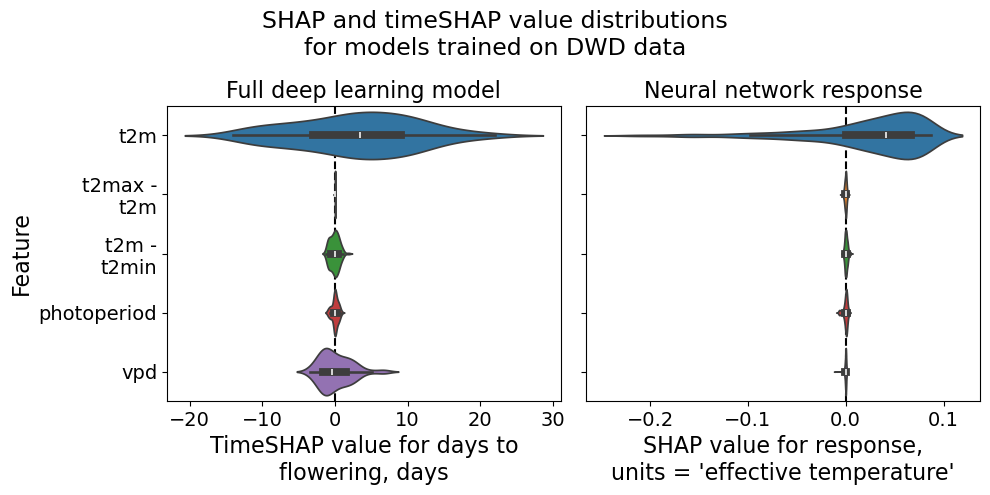

In [38]:
font_size = 14
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]
sns.violinplot(data=shap_df_DE, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_xlabel('TimeSHAP value for days to\nflowering, days', fontsize = font_size + 2)
ax.set_ylabel('Feature', fontsize = font_size + 2)
ax.set_title('Full deep learning model', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size)

ax = axs[1]
sns.violinplot(data=shap_resp_DE, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_ylabel(None)
ax.set_xlabel('SHAP value for response,\nunits = \'effective temperature\'', fontsize = font_size + 2)
ax.set_title('Neural network response', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size, labelleft = False)

fig.suptitle('SHAP and timeSHAP value distributions\nfor models trained on DWD data', fontsize = font_size + 3)
fig.tight_layout()

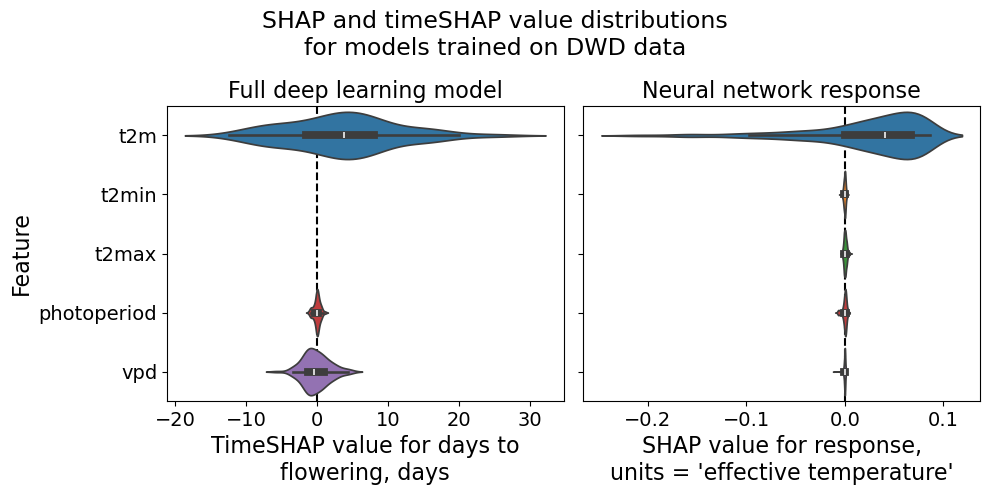

In [84]:
font_size = 14
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]
sns.violinplot(data=shap_df_DE, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_xlabel('TimeSHAP value for days to\nflowering, days', fontsize = font_size + 2)
ax.set_ylabel('Feature', fontsize = font_size + 2)
ax.set_title('Full deep learning model', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size)

ax = axs[1]
sns.violinplot(data=shap_resp_DE, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_ylabel(None)
ax.set_xlabel('SHAP value for response,\nunits = \'effective temperature\'', fontsize = font_size + 2)
ax.set_title('Neural network response', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size, labelleft = False)

fig.suptitle('SHAP and timeSHAP value distributions\nfor models trained on DWD data', fontsize = font_size + 3)
fig.tight_layout()

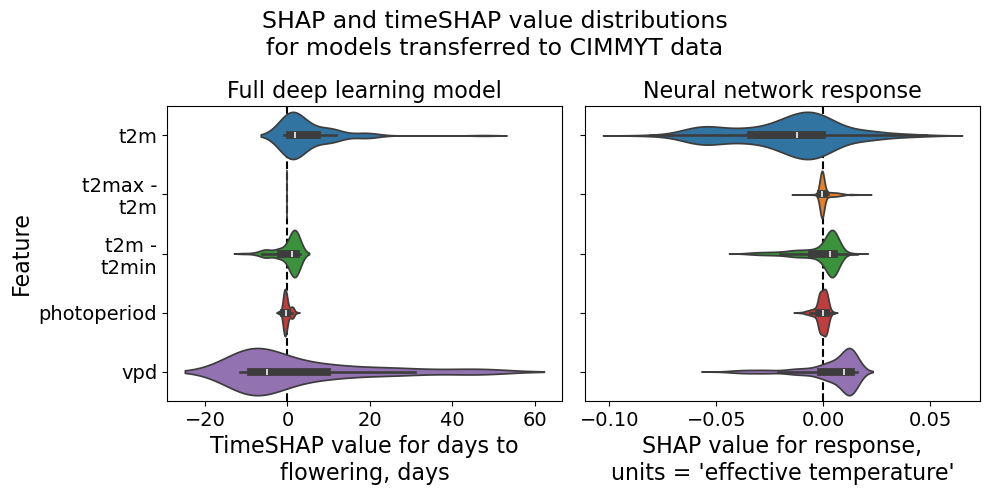

In [39]:
font_size = 14
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]
sns.violinplot(data=shap_df_SSA, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_xlabel('TimeSHAP value for days to\nflowering, days', fontsize = font_size + 2)
ax.set_ylabel('Feature', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size)
ax.set_title('Full deep learning model', fontsize = font_size + 2)

ax = axs[1]
sns.violinplot(data=shap_resp_SSA, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_ylabel(None)
ax.set_xlabel('SHAP value for response,\nunits = \'effective temperature\'', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size, labelleft = False)
ax.set_title('Neural network response', fontsize = font_size + 2)

fig.suptitle('SHAP and timeSHAP value distributions\nfor models transferred to CIMMYT data', fontsize = font_size + 3)
fig.tight_layout()

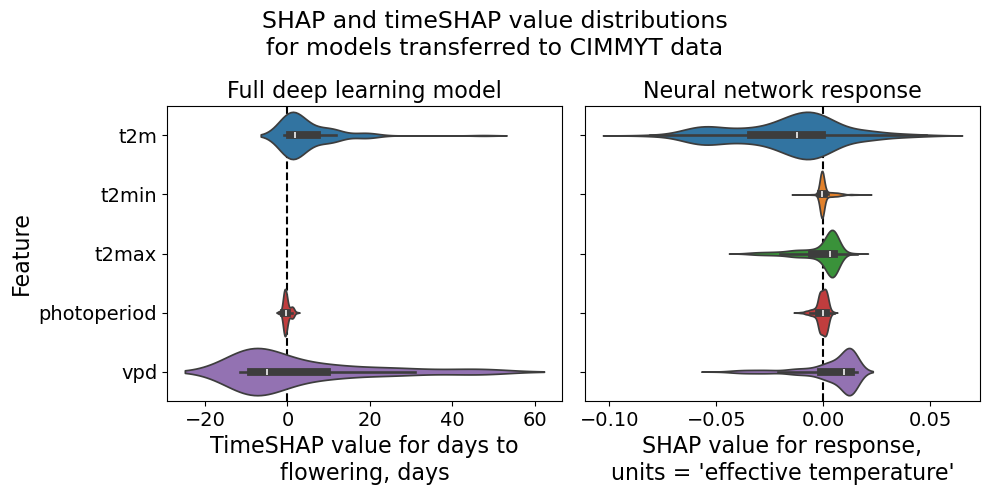

In [85]:
font_size = 14
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

ax = axs[0]
sns.violinplot(data=shap_df_SSA, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_xlabel('TimeSHAP value for days to\nflowering, days', fontsize = font_size + 2)
ax.set_ylabel('Feature', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size)
ax.set_title('Full deep learning model', fontsize = font_size + 2)

ax = axs[1]
sns.violinplot(data=shap_resp_SSA, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_ylabel(None)
ax.set_xlabel('SHAP value for response,\nunits = \'effective temperature\'', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size, labelleft = False)
ax.set_title('Neural network response', fontsize = font_size + 2)

fig.suptitle('SHAP and timeSHAP value distributions\nfor models transferred to CIMMYT data', fontsize = font_size + 3)
fig.tight_layout()

In [25]:
bs = 500
n_channels = 5

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32 #8 for SSA, 32 for DE
num_layers = 3 #2 for SSA
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_KG_DE_pre_2022_small'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small'
save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'
save_name = 'CCNN_KG_DE_pre_2022_RMSE_loss' 
save_name = 'CCNN_KG_DE_pre_2022_RMSE_loss' 
save_name = 'CCNN_KG_DE_pre_2022_for_TL_huge'
#save_name = 'KFold1'

bce = True
CNN = True
MMD = False
regression=False
KG=True#True if not doing response adjustment (!!!!!)
KG_vpd = False
normalise_at_end = False
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = KG, MMD=MMD, regression=regression, KG_vpd=KG_vpd, normalise_at_end=normalise_at_end)#, target_features=temp_NDVI_series_SSA)
#save_name = 'CCNN_KG_DE_pre_2022_dev_stage_small_tmax_fix'
trained_model = load_model(save_name, model)
#background = temp_NDVI_series_DE.mean(dim=0).numpy()[:4, :].swapaxes(0, 1)
#background_GDD = temp_NDVI_series_DE.mean(dim=0).numpy()[[0], :].swapaxes(0, 1)
#background=np.zeros(background.shape)
input_xb = temp_NDVI_series_DE.numpy()[random_indices, :n_channels, :].swapaxes(1, 2)
#input_xb = temp_NDVI_series_SSA.numpy()[:, :4, :].swapaxes(1, 2)
T_min = 9 + 10*(torch.tanh(trained_model.u1.data).numpy()[0]) - 4 #normally multiplier = 2
T_opt = 28 + 7*(torch.tanh(trained_model.u2.data).numpy()[0]) - 4 #normally multiplier = 3
T_max = 39 + 3.5*torch.tanh(trained_model.u3.data).numpy()[0] - 2 #normally no multiplier
alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
beta = 1
x = input_xb
#x[:, :, 0] = trained_model.u0.data.numpy()[0] * (x[:, :, 0] <= T_max) * ( ((2*((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha))*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha))
#x[:, :, 0] = response(x[:, :, 0])
#x[:, :, 0] = response(x[:, :, 0])
input_xb = x
background = input_xb.mean(axis=0)

In [25]:
def run_for_timeshap_wrapper(xb):
    return run_for_timeshap(xb.swapaxes(1, 2), trained_model)
for event_number in range(1000):
    if event_number % 10 == 0:
        print('Processing event ', event_number)
    df = event_level(run_for_timeshap_GDD_wrapper,
                    input_xb_GDD[[event_number], :, :],
                    background_GDD,
                    0,
                    3,
                    nsamples=3200,
                    )
    df['Sample number'] = event_number
    if event_number == 0:
        all_df_GDD = df
    else:
        all_df_GDD = pd.concat([all_df_GDD, df], axis = 0)

Processing event  0


NameError: name 'background_GDD' is not defined

In [44]:
def run_for_timeshap_wrapper(xb):
    return run_for_timeshap(xb.swapaxes(1, 2), trained_model)
for event_number in range(1000):
    if event_number % 10 == 0:
        print('Processing event ', event_number)
    df = feature_level(run_for_timeshap_wrapper,
                    input_xb[[event_number], :, :],
                    background,
                    0,
                    3,
                    nsamples=3200,
                    )
    df['Sample number'] = event_number
    if event_number == 0:
        all_df_features = df
    else:
        all_df_features = pd.concat([all_df_features, df], axis = 0)

Processing event  0
Processing event  10
Processing event  20
Processing event  30
Processing event  40
Processing event  50
Processing event  60
Processing event  70
Processing event  80
Processing event  90
Processing event  100
Processing event  110
Processing event  120
Processing event  130
Processing event  140
Processing event  150
Processing event  160
Processing event  170
Processing event  180
Processing event  190
Processing event  200
Processing event  210
Processing event  220
Processing event  230
Processing event  240
Processing event  250
Processing event  260
Processing event  270
Processing event  280
Processing event  290
Processing event  300
Processing event  310
Processing event  320
Processing event  330
Processing event  340
Processing event  350
Processing event  360
Processing event  370
Processing event  380
Processing event  390
Processing event  400
Processing event  410
Processing event  420
Processing event  430
Processing event  440
Processing event  450

In [45]:
all_df_features.loc[all_df_features['Feature'] == 'Feature 0', 'Feature'] = 't2m'
all_df_features.loc[all_df_features['Feature'] == 'Feature 1', 'Feature'] = 't2max -\nt2m'
all_df_features.loc[all_df_features['Feature'] == 'Feature 2', 'Feature'] = 't2m -\nt2min'
all_df_features.loc[all_df_features['Feature'] == 'Feature 3', 'Feature'] = 'photoperiod'
all_df_features.loc[all_df_features['Feature'] == 'Feature 4', 'Feature'] = 'vpd'

In [42]:
shap_df = pd.pivot_table(all_df_features, values = 'Shapley Value', columns = 'Feature', index='Sample number')
neworder = ['t2m','t2min','t2max','photoperiod','vpd']
shap_df=shap_df.reindex(columns=neworder)

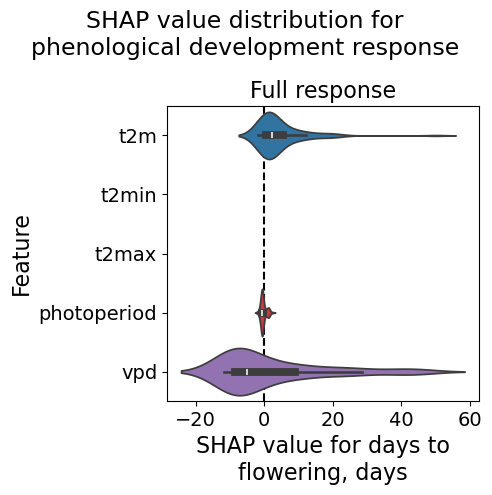

In [57]:
font_size = 14
fig, ax = plt.subplots(figsize = (5, 5))
sns.violinplot(data=shap_df_SSA, orient = 'h', ax=ax, zorder = 1)
ax.axvline(0, color='k', linestyle='--', zorder = 0)
ax.set_xlabel('SHAP value for days to\nflowering, days', fontsize = font_size + 2)
ax.set_ylabel('Feature', fontsize = font_size + 2)
ax.set_title('Full response', fontsize = font_size + 2)
ax.tick_params(labelsize = font_size)
fig.suptitle('SHAP value distribution for\nphenological development response', fontsize = font_size + 3)
fig.tight_layout()

In [ ]:
def run_for_timeshap_wrapper(xb):
    return run_for_timeshap(xb.swapaxes(1, 2), trained_model)
for event_number in range(1000):
    if event_number % 10 == 0:
        print('Processing event ', event_number)
    df = event_level(run_for_timeshap_wrapper,
                    input_xb[[event_number], :, :],
                    background,
                    0,
                    3,
                    nsamples=3200,
                    )
    df['Sample number'] = event_number
    if event_number == 0:
        all_df_CCNN = df
    else:
        all_df_CCNN = pd.concat([all_df_CCNN, df], axis = 0)
#local_report(lambda xb: run_for_timeshap(xb.swapaxes(1, 2), trained_model), 
#                                input_xb[[0], :, :], pruning_dict, event_dict, feature_dict, cell_dict, baseline=background)

Processing event  0
Processing event  10
Processing event  20
Processing event  30
Processing event  40
Processing event  50
Processing event  60
Processing event  70
Processing event  80
Processing event  90
Processing event  100
Processing event  110
Processing event  120
Processing event  130
Processing event  140
Processing event  150
Processing event  160
Processing event  170
Processing event  180
Processing event  190
Processing event  200
Processing event  210
Processing event  220
Processing event  230
Processing event  240
Processing event  250
Processing event  260
Processing event  270
Processing event  280
Processing event  290
Processing event  300
Processing event  310
Processing event  320
Processing event  330
Processing event  340
Processing event  350
Processing event  360
Processing event  370
Processing event  380
Processing event  390
Processing event  400
Processing event  410
Processing event  420
Processing event  430
Processing event  440
Processing event  450

In [ ]:
#temp_indexing = temp_NDVI_series_DE[:, [0], :]#.shape
#input_xb_GDD = temp_indexing.numpy()[np.random.choice(temp_NDVI_series_DE.shape[0], 1000), :, :].swapaxes(1, 2)
#def run_for_timeshap_GDD_wrapper(xb):
#    df = pd.DataFrame()
#    df[[f't2m at day {n}' for n in range(163)]] = xb.swapaxes(1, 2).squeeze(axis=1)
#    df['year'] = range(len(df))
#    df['Stations_id'] = 0
#    cf = run_GDD([0.587931, 9.3, 28.3, 39.2, 8, 3], df, 't2m', response_type='Convolved_vary_spread',#_early
#        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=163,
#        thresholds = [20], title_extra='Early varieties', method = 'regression', plot=False)
#    return cf['modelled time to beginning of flowering'].values

In [ ]:
#import shap
#explainer = shap.KernelExplainer(lambda xb: run_for_timeshap(xb.swapaxes(1, 2), trained_model),
#                                 temp_NDVI_series_DE[:1000, :4, :].swapaxes(1, 2).numpy())
#shap_values = explainer.shap_values(input_xb[0,:, :])
#shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])

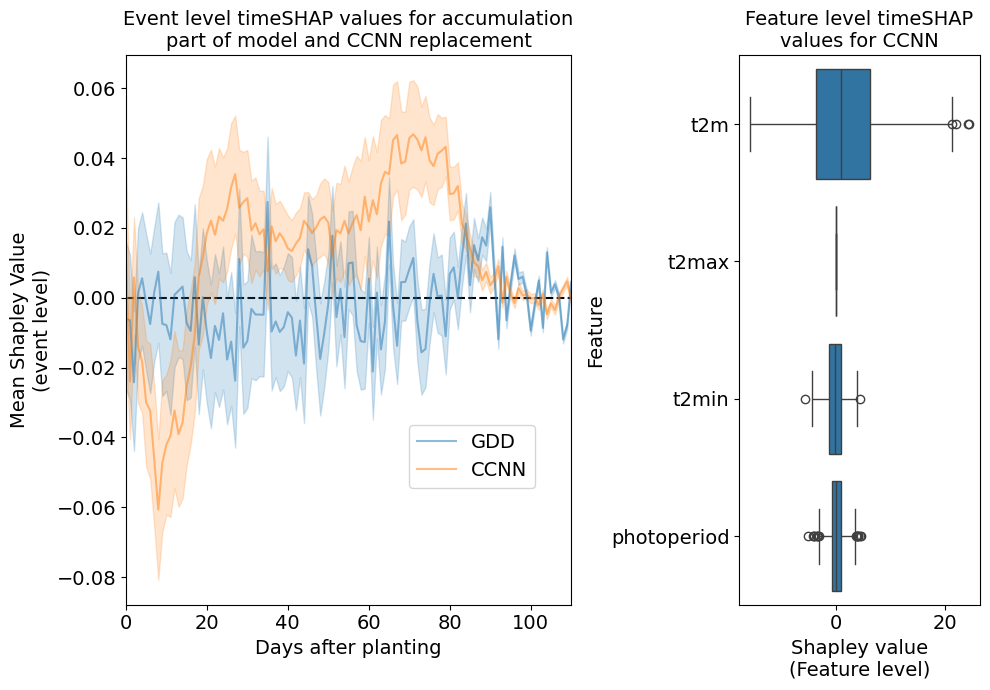

In [ ]:
font_size = 14
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(10)#22
axs = []
axs.append(plt.subplot2grid(shape=(3, 5), loc=(0, 0), colspan=3, rowspan = 3))
axs.append(plt.subplot2grid(shape=(3, 5), loc=(0, 3), colspan=2, rowspan = 3))#axs.append(plt.subplot2grid(shape=(3, 10), loc=(0, 3), colspan=3, rowspan = 3))
ax = axs[0]
#df_transformed_GDD = feats_to_dayofseason(all_df_GDD)
#df_transformed_CCNN = feats_to_dayofseason(all_df_CCNN)
sns.lineplot(data=df_transformed_GDD, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'GDD', zorder = 2, legend=False)
sns.lineplot(data=df_transformed_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'CCNN', zorder = 2, legend=False)
ax.set_xlim([0, 110])
ax.axhline(0, color = 'k', linestyle = '--', zorder = 0)
ax.set_xlabel('Days after planting', fontsize = font_size)
ax.set_ylabel('Mean Shapley Value\n(event level)', fontsize = font_size)
ax.tick_params(labelsize = font_size)
fig.legend(bbox_to_anchor = (0.55, 0.4), fontsize = font_size)
ax.set_title('Event level timeSHAP values for accumulation\npart of model and CCNN replacement', fontsize = font_size)
#sns.lineplot(data=all_df_GDD, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'GDD')
#sns.lineplot(data=all_df_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'CCNN')
#xticks = ax.set_xticks(list(range(0, 180, 10)), list(range(0, 180, 10)))
ax = axs[1]
sns.boxplot(data=all_df_features, x='Shapley Value', y='Feature', ax=ax)#, orient = 'v')#, stat='density', common_norm=False, bins = 10)
ax.set_yticks([0, 1, 2, 3], ['t2m', 't2max', 't2min', 'photoperiod'])#, labelsize = font_size)
ax.tick_params(labelsize = font_size)
ax.set_xlabel('Shapley value\n(Feature level)', fontsize = font_size)
ax.set_ylabel('Feature', fontsize = font_size)
ax.set_title('Feature level timeSHAP\nvalues for CCNN', fontsize = font_size)
fig.tight_layout()

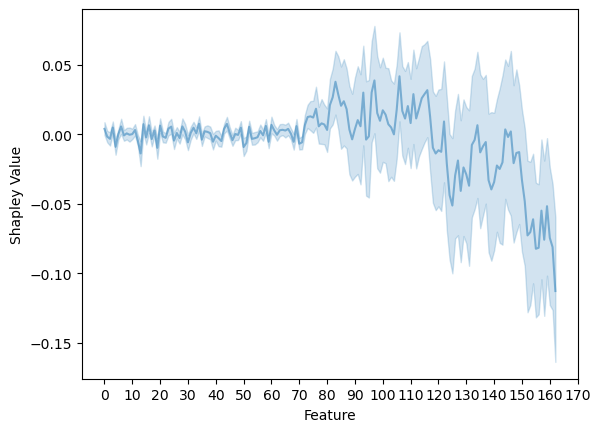

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=all_df_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax)
ax.set_xticks(list(range(180, 5)), list(range(180, 5)))
xticks = ax.set_xticks(list(range(0, 180, 10)), list(range(0, 180, 10)))

Text(0.5, 1.0, 'SHAP values from GDD model and interpretation from\nresponse functions')

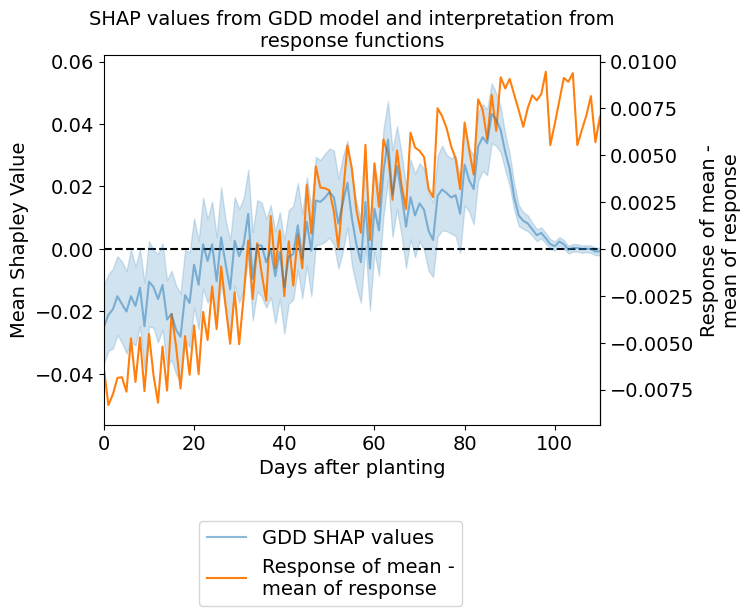

In [ ]:
w = 8
font_size = 14
fig, ax = plt.subplots()
df_transformed_GDD = feats_to_dayofseason(all_df_GDD)
#df_transformed_CCNN = feats_to_dayofseason(all_df_CCNN)
#sns.lineplot(data=df_transformed_GDD, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'GDD SHAP values', zorder = 2, legend=False)
#sns.lineplot(data=df_transformed_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'CCNN', zorder = 2)
temp_discrep = (response(temp_indexing.numpy().swapaxes(1, 2)) - response(temp_indexing.numpy().swapaxes(1, 2).mean(axis=0))).mean(axis = 0)#background_GDD(response(input_xb_GDD) - response(background_GDD)).mean(axis = 0)#np.convolve((response(input_xb_GDD) - response(background_GDD)).mean(axis = 0).squeeze(), np.ones(w), 'valid') / w
ax.plot(range(163), -(6*temp_discrep), zorder = 1, label = 'Response of mean -\nmean of response')
ax.set_xlim([0, 110])
ax.axhline(0, color = 'k', linestyle = '--', zorder = 0)
ax.set_xlabel('Days after planting', fontsize = font_size)
ax.set_ylabel('Mean Shapley Value', fontsize = font_size)
def coords_to_resps(x):
    return x/6
def resps_to_coords(y):
    return 6*y
secax_y = ax.secondary_yaxis('right', functions=(coords_to_resps, resps_to_coords))
secax_y.set_ylabel('Response of mean -\nmean of response', fontsize = font_size)
secax_y.tick_params(labelsize = font_size)
ax.tick_params(labelsize = font_size)
fig.legend(bbox_to_anchor = (0.7, -0.07), fontsize = font_size)
ax.set_title('SHAP values from GDD model and interpretation from\nresponse functions', fontsize = font_size)

#sns.lineplot(data=all_df_GDD, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'GDD')
#sns.lineplot(data=all_df_CCNN, x='Feature', y='Shapley Value',  alpha=0.5, ax=ax, label = 'CCNN')
#xticks = ax.set_xticks(list(range(0, 180, 10)), list(range(0, 180, 10)))

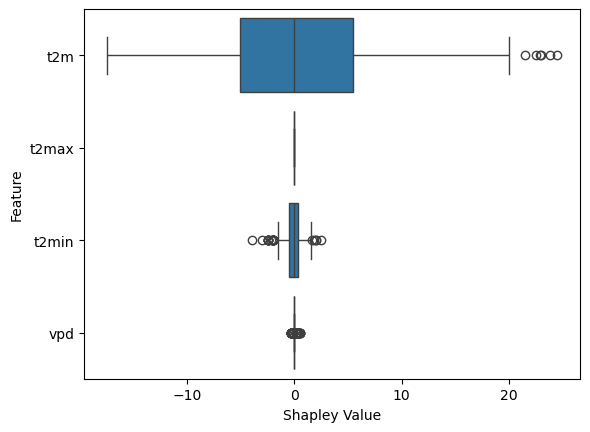

In [ ]:
ax = sns.boxplot(data=all_df_features, x='Shapley Value', y='Feature')#, orient = 'v')#, stat='density', common_norm=False, bins = 10)
ax.set_yticks([0, 1, 2, 3], ['t2m', 't2max', 't2min', 'vpd'])

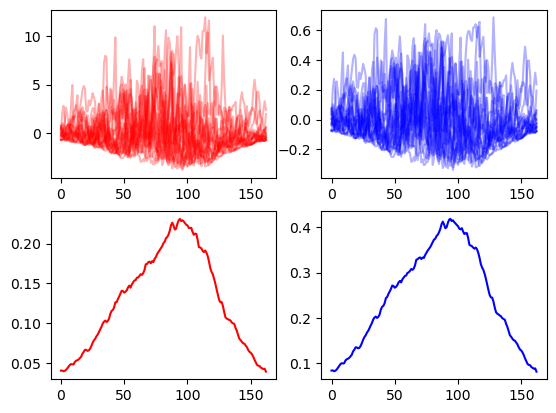

In [ ]:
fig, axs = plt.subplots(2, 2)
for ind in range(800, 820):
    axs[0, 0].plot(input_xb[ind, :, 0] - background[:, 0], color = 'red', alpha = 0.3)#input_xb_GDD.mean(axis=0)
    axs[0, 1].plot(input_xb_GDD[ind, :, 0] - background_GDD[:, 0], color = 'blue', alpha = 0.3)#background_GDD[:, 0]
axs[1, 0].plot(background[:, 0]/20, color = 'red')
axs[1, 1].plot(background_GDD[:, 0], color = 'blue')#input_xb_GDD.mean(axis=0)